<a href="https://colab.research.google.com/github/andrehuang/examples/blob/mnist/mnist_training_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


In [137]:
import seaborn as sns
sns.set()

In [418]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x # for cross entropy loss 
        # output = F.log_softmax(x, dim=1) # for nll loss
        return output
      

    def feature_list(self, x):
        out_list = []
        out = F.relu(self.conv1(x))
        out_list.append(out.contiguous().view(out.size(0), -1))
        out = F.relu(self.conv2(out))
        out_list.append(out.contiguous().view(out.size(0), -1))
        out = F.max_pool2d(out, 2)
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out_list.append(out.contiguous().view(out.size(0), -1))
        out = self.fc2(out)
        out_list.append(out.contiguous().view(out.size(0), -1))
        # y = F.softmax(out, dim=1)
        return out_list
    
    def mean_feat_list(self, x):
        out_list = []
        out = F.relu(self.conv1(x))
        out_list.append(out.contiguous().view(out.size(0), -1).mean(dim=0, keepdim=True))
        out = F.relu(self.conv2(out))
        out_list.append(out.contiguous().view(out.size(0), -1).mean(dim=0, keepdim=True))
        out = F.max_pool2d(out, 2)
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out_list.append(out.contiguous().view(out.size(0), -1).mean(dim=0, keepdim=True))
        out = self.fc2(out)
        out_list.append(out.contiguous().view(out.size(0), -1).mean(dim=0, keepdim=True))
        return out_list

    # function to extact a specific feature
    def intermediate_forward(self, x, layer_index):
        x = self.conv1(x)
        out = F.relu(x)
        if layer_index == 1:
            out = F.relu(self.conv2(out))
        elif layer_index == 2:
            out = F.relu(self.conv2(out))
            out = F.max_pool2d(out, 2)
            out = torch.flatten(out, 1)
            out = F.relu(self.fc1(out))
        elif layer_index == 3:
            out = F.relu(self.conv2(out))
            out = F.max_pool2d(out, 2)
            out = torch.flatten(out, 1)
            out = F.relu(self.fc1(out))
            out = self.fc2(out) 
        return out


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            torch.save(model.state_dict(), f"./models/mnist_cnn_step{batch_idx}.pth")



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [419]:
args = {}
args['batch_size']=64
args['test_batch_size']=1000
args['epochs']=14  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=1.0 #Learning rate is how fast it will decend. 
args['gamma']=0.7 

args['seed']=1 #random seed
args['log_interval']=50
args['cuda']=True
args['save-model'] = False

In [420]:
use_cuda = args['cuda']
torch.manual_seed(args['seed'])
device = torch.device("cuda" if use_cuda else "cpu")

In [421]:
train_kwargs = {'batch_size': args['batch_size']}
test_kwargs = {'batch_size': args['test_batch_size']}
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

In [422]:
dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
dataset3 = datasets.FashionMNIST('../data', train=False, download=True,
                       transform=transform)

In [423]:
dataset3.data.shape

torch.Size([10000, 28, 28])

In [424]:
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args['lr'])

scheduler = StepLR(optimizer, step_size=1, gamma=args['gamma'])

In [425]:
for epoch in range(1, args['epochs'] + 1):
    if epoch == 2:
      break
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
    

# if args['save_model']:
#     torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311152
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.208529
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.232101
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.158483
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.156021
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.337393
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.213747
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.082443
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.076199
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.089883
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.110103
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.277865
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.101555
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.193174
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.172374
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.154327
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.105742
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.028043
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.138034

Test set: Average loss: 0.0508, Accuracy: 9840/10000 (98%)

In [ ]:
!ls

models	sample_data


In [449]:
model1 = Net().to(device)
model1.load_state_dict(torch.load("./models/mnist_cnn_step500.pth"))

<All keys matched successfully>

In [450]:
def manual_transform(np_data):
  # transforms.Normalize((0.1307,), (0.3081,))
  np_data /= 255
  np_data = (np_data - 0.1307)/0.3081
  return np_data
fmnist_test_data = manual_transform(dataset3.data.float().reshape((-1, 1, 28, 28))).cuda()
mnist_test_data = manual_transform(dataset2.data.float().reshape((-1, 1, 28, 28))).cuda()


In [451]:
with torch.no_grad():
  mnist_feats = model1.feature_list(mnist_test_data[:1000])[-1].detach().cpu().numpy()
  fmnist_feats = model1.feature_list(fmnist_test_data[:1000])[-1].detach().cpu().numpy()

In [452]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(mnist_feats)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [453]:
fmnist_pca = pca.transform(fmnist_feats)
mnist_pca = pca.transform(mnist_feats)

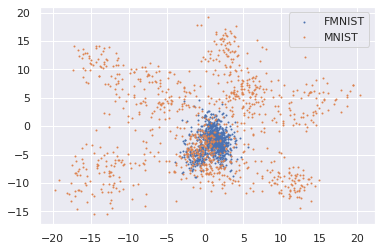

In [454]:
plt.scatter(fmnist_pca[:,0], fmnist_pca[:, 1], s=1)
plt.scatter(mnist_pca[:,0], mnist_pca[:, 1], s=1)
plt.legend(['FMNIST', 'MNIST'])
# plt.savefig('./plots/epoch9_feats.pdf')

In [455]:
train_kwargs = {'batch_size': 1}
test_kwargs = {'batch_size': 1}
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
ftest_loader = torch.utils.data.DataLoader(dataset3, **test_kwargs)

In [456]:
from tqdm import tqdm

In [457]:
train_grad_list = []
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx == 1000:
       break
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = F.cross_entropy(output, target)
    grads = torch.autograd.grad(loss, model.parameters(), retain_graph = True) # extract NN gradients
    train_grad_list.append(grads)

In [458]:
train_num = 100
M_testvtrain = torch.zeros((10, 100, train_num))
for d in tqdm(range(10)):
  for i, (data, target) in enumerate(test_loader):
      if i == 100:
        break
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = F.cross_entropy(output, target)
      # grads = torch.autograd.grad(loss, model.parameters(), retain_graph = True) # extract NN gradients
      grads = torch.autograd.grad(output[0][d], model.parameters(), retain_graph = True) # extract NN gradients
      for j in range(train_num):
        pt_grad = train_grad_list[j]
        M_testvtrain[d, i, j] = sum([torch.sum(torch.mul(grads[u], pt_grad[u])) for u in range(len(grads))])
M_test = M_testvtrain.sum(dim=2) # sum all the training data, get 1*1 result for each test data point.
torch.save(M_test, './results/M_test')














  0%|          | 0/10 [00:00<?, ?it/s]











 10%|█         | 1/10 [00:02<00:26,  2.98s/it]











 20%|██        | 2/10 [00:06<00:24,  3.04s/it]











 30%|███       | 3/10 [00:09<00:21,  3.12s/it]











 40%|████      | 4/10 [00:12<00:18,  3.16s/it]











 50%|█████     | 5/10 [00:15<00:15,  3.08s/it]











 60%|██████    | 6/10 [00:18<00:12,  3.13s/it]











 70%|███████   | 7/10 [00:22<00:09,  3.22s/it]











 80%|████████  | 8/10 [00:25<00:06,  3.17s/it]











 90%|█████████ | 9/10 [00:28<00:03,  3.13s/it]











100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


In [459]:
# M_testvtrain0 = M_testvtrain0.sum(dim=1) # sum all the training data, get 1*1 result for each test data point.

In [460]:
# M_testvtrain0.shape

In [476]:
F_testvtrain = torch.zeros((10, 100, train_num))
for d in tqdm(range(10)):
  for i, (data, target) in enumerate(ftest_loader):
      if i == 100:
        break
      data = torch.rand((1, 1, 28, 28))
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = F.cross_entropy(output, target)
      # grads = torch.autograd.grad(loss, model.parameters(), retain_graph = True) # extract NN gradients
      grads = torch.autograd.grad(output[0][d], model.parameters(), retain_graph = True) # extract NN gradients
      for j in range(train_num):
        pt_grad = train_grad_list[j]
        F_testvtrain[d, i, j] = sum([torch.sum(torch.mul(grads[u], pt_grad[u])) for u in range(len(grads))])
F_test = F_testvtrain.sum(dim=2)
# torch.save(F_test, './results/F_test')














  0%|          | 0/10 [00:00<?, ?it/s]












 10%|█         | 1/10 [00:02<00:26,  2.90s/it]












 20%|██        | 2/10 [00:05<00:23,  2.93s/it]












 30%|███       | 3/10 [00:08<00:20,  2.94s/it]












 40%|████      | 4/10 [00:11<00:17,  2.92s/it]












 50%|█████     | 5/10 [00:14<00:14,  2.97s/it]












 60%|██████    | 6/10 [00:17<00:11,  2.95s/it]












 70%|███████   | 7/10 [00:20<00:08,  2.93s/it]












 80%|████████  | 8/10 [00:23<00:05,  2.97s/it]












 90%|█████████ | 9/10 [00:26<00:02,  2.96s/it]












100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


In [462]:
# F_testvtrain0 = F_testvtrain0.sum(dim=1) # sum all the training data, get 1*1 result for each test data point.
# F_test = F_testvtrain.sum(dim=2)
# torch.save(F_test, './results/F_test')

In [463]:
M_test.mean()

tensor(-49.9300)

In [464]:
F_test.mean()

tensor(-49.1501)

In [465]:
M_test.std()

tensor(131.6106)

In [466]:
F_test.std()

tensor(95.6422)

In [467]:
M_test_norm = M_test.norm(dim=0, p=1)
F_test_norm = F_test.norm(dim=0, p=1)

In [468]:
M_test_norm.mean()

tensor(1029.5476)

In [469]:
F_test_norm.mean()

tensor(803.5161)

In [470]:
M_test_norm.std()

tensor(498.6613)

In [471]:
F_test_norm.std()

tensor(440.6486)

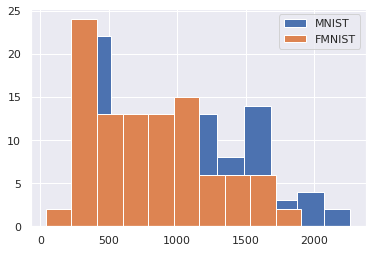

In [472]:
plt.hist(M_test_norm)
plt.hist(F_test_norm)
plt.legend(['MNIST', 'FMNIST'])

In [395]:
M_testvtrain_loss = torch.zeros((100, 100))
for i, (data, target) in enumerate(test_loader):
      if i == 100:
        break
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = F.cross_entropy(output, target)
      grads = torch.autograd.grad(loss, model.parameters(), retain_graph = True) # extract NN gradients
      # grads = torch.autograd.grad(output[0][d], model.parameters(), retain_graph = True) # extract NN gradients
      for j in range(100):
        pt_grad = train_grad_list[j]
        M_testvtrain_loss[i, j] = sum([torch.sum(torch.mul(grads[u], pt_grad[u])) for u in range(len(grads))])
M_test_l = M_testvtrain_loss.sum(dim=1) # sum all the training data, get 1*1 result for each test data point.
torch.save(M_test_l, './results/M_test_l')

In [376]:
F_testvtrain_loss = torch.zeros((100, 100))
for i, (data, target) in enumerate(ftest_loader):
      if i == 100:
        break
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = F.cross_entropy(output, target)
      grads = torch.autograd.grad(loss, model.parameters(), retain_graph = True) # extract NN gradients
      # grads = torch.autograd.grad(output[0][d], model.parameters(), retain_graph = True) # extract NN gradients
      for j in range(100):
        pt_grad = train_grad_list[j]
        F_testvtrain_loss[i, j] = sum([torch.sum(torch.mul(grads[u], pt_grad[u])) for u in range(len(grads))])
F_test_l = F_testvtrain_loss.sum(dim=1) # sum all the training data, get 1*1 result for each test data point.
torch.save(F_test_l, './results/F_test_l')

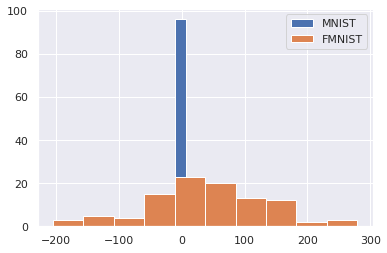

In [377]:
plt.hist(M_test_l)
plt.hist(F_test_l)
plt.legend(['MNIST', 'FMNIST'])

In [378]:
M_test_l

tensor([-1.0552e-05, -3.1789e-02,  4.3957e-04, -1.0711e-02, -1.1098e-02,
         2.3596e-04, -3.7610e-02,  4.5247e+00, -1.8947e+00,  1.0049e-01,
        -3.2109e-03, -5.8095e-04,  2.6089e-02, -4.5048e-04,  2.2567e-04,
        -2.7807e-02,  4.0035e-02, -4.6064e-05,  3.8473e+00, -4.9435e-03,
         3.4693e-01,  2.0308e-01, -1.2748e-02, -7.3925e-03, -3.6336e-01,
        -9.4958e-03, -1.5129e-01, -2.6902e-04, -9.5175e-03, -4.0227e-03,
        -3.4635e-03, -8.9643e-02,  1.7424e-03, -2.4735e-01,  3.3780e-05,
        -1.5351e-03,  1.6614e-02, -1.6886e-03, -2.4970e-01,  2.2252e-04,
         4.1099e-03, -5.7268e-02, -1.3634e+00, -5.4772e-01,  4.4590e-02,
        -1.3489e-02, -1.7130e-01, -5.3028e-05, -6.5378e-02, -2.4125e-02,
         2.6150e-02, -4.2433e-03, -1.8259e-03, -1.9475e-02,  1.1270e-01,
         2.7639e-04, -2.7364e-05,  4.6898e-04,  4.5780e-03, -1.0397e+01,
        -3.9775e-03, -3.8726e-03,  1.6060e+02,  9.2269e-03,  1.2915e-04,
        -5.4726e+00, -4.2980e-02, -5.0673e-02, -6.0